In [2]:
import os
import pickle
import random
import re
import string
import warnings

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from scipy import stats
from sklearn import preprocessing, utils
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from wordcloud import WordCloud
from xgboost import XGBRegressor

In [3]:
data = pd.read_csv('../input/google-quest-challenge-files/data/train.csv')
# data = pd.read_csv('./data/train.csv')
train_cols = ['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host']
X = data[train_cols]
y = data.drop(columns=train_cols)

In [4]:
X.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com


In [5]:
y.head(2)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,1.0,0.333333,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,1.0,1.000000,0.0,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


In [6]:
question_related_aspects = []
answer_related_aspects = []

for col in y.columns:
    if 'question' in col:
        question_related_aspects.append(col)
    else:
        answer_related_aspects.append(col)

print(f" Aspects related to question : {len(question_related_aspects)} - {question_related_aspects}")
print()
print(f" Aspects related to answer : {len(answer_related_aspects)} - {answer_related_aspects}")

 Aspects related to question : 21 - ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']

 Aspects related to answer : 9 - ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)
print("y_train Shape : ", y_train.shape)
print("X_test Shape : ", y_test.shape)


X_train Shape :  (4863, 11)
X_test Shape :  (1216, 11)
y_train Shape :  (4863, 30)
X_test Shape :  (1216, 30)


In [8]:
categorical_features = ['qa_id', 'question_user_name', 'question_user_page', 'answer_user_name',
                         'answer_user_page', 'url', 'category', 'host']
for i in categorical_features:
    print(f'Cadinality of feature {i} - {X[i].nunique()}')

Cadinality of feature qa_id - 6079
Cadinality of feature question_user_name - 3215
Cadinality of feature question_user_page - 3422
Cadinality of feature answer_user_name - 4114
Cadinality of feature answer_user_page - 4430
Cadinality of feature url - 3583
Cadinality of feature category - 5
Cadinality of feature host - 63


In [9]:
X_train = X_train[['question_title', 'question_body', 'answer', 'category', 'host']]
X_test = X_test[['question_title', 'question_body', 'answer', 'category', 'host']]

In [10]:
miss = len(X_train['category'].isnull())
total = len(X_train['category'])
print(f"Number of NULL Values in test data, category column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")

miss = len(X_test['category'].isnull())
total = len(X_test['category'])
print(f"Number of NULL Values in test data, category column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")

Number of NULL Values in test data, category column is 4863 out if 4863. Percent of missing value: 0.0%.
Number of NULL Values in test data, category column is 1216 out if 1216. Percent of missing value: 0.0%.


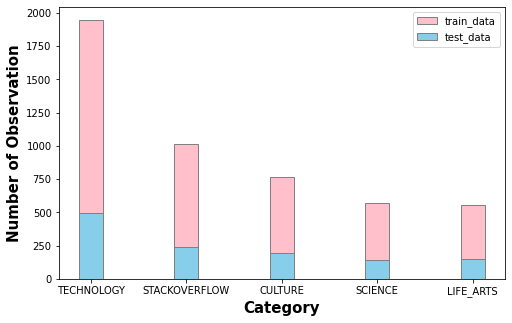

In [11]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))

# set height of bar
train_data_category = X_train['category'].value_counts()
# print(train_data_category)
test_data_category = X_test['category'].value_counts()
test_data_category = test_data_category.loc[train_data_category.index]
# print(test_data_category)

# Set position of bar on X axis
br1 = np.arange(len(train_data_category))
br2 = [x for x in br1]

# Make the plot
plt.bar(br1, train_data_category, color ='#FFC0CB', width = barWidth,
		edgecolor ='grey', label ='train_data')
plt.bar(br2, test_data_category, color ='#87CEEB', width = barWidth,
		edgecolor ='grey', label ='test_data')


# Adding Xticks
plt.xlabel('Category', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Observation', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(train_data_category))],
		train_data_category.index)

plt.legend()
plt.show()


In [12]:
miss = len(X_train['host'].isnull())
total = len(X_train['host'])
print(f"Number of NULL Values in train data, host column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")

miss = len(X_test['host'].isnull())
total = len(X_test['host'])
print(f"Number of NULL Values in test data, host column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")

Number of NULL Values in train data, host column is 4863 out if 4863. Percent of missing value: 0.0%.
Number of NULL Values in test data, host column is 1216 out if 1216. Percent of missing value: 0.0%.


In [13]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

def decontracted(phrase):
    phrase = re.sub(r"(W|w)on(\'|\’)t ", "will not ", phrase)
    phrase = re.sub(r"(C|c)an(\'|\’)t ", "can not ", phrase)
    phrase = re.sub(r"(Y|y)(\'|\’)all ", "you all ", phrase)
    phrase = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", phrase)
    phrase = re.sub(r"(I|i)(\'|\’)m ", "i am ", phrase)
    phrase = re.sub(r"(A|a)isn(\'|\’)t ", "is not ", phrase)
    phrase = re.sub(r"n(\'|\’)t ", " not ", phrase)
    phrase = re.sub(r"(\'|\’)re ", " are ", phrase)
    phrase = re.sub(r"(\'|\’)d ", " would ", phrase)
    phrase = re.sub(r"(\'|\’)ll ", " will ", phrase)
    phrase = re.sub(r"(\'|\’)t ", " not ", phrase)
    phrase = re.sub(r"(\'|\’)ve ", " have ", phrase)
    return phrase

def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '12345', x)
    x = re.sub('[0-9]{4}', '1234', x)
    x = re.sub('[0-9]{3}', '123', x)
    x = re.sub('[0-9]{2}', '12', x)
    return x

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]


stemmer = SnowballStemmer("english")

# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = clean_text(sentance)
        sent = clean_numbers(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(stemmer.stem(e) for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text


def special_symbols(string):
    pattern = r'[^a-zA-Z0-9\s]'
    matches = re.finditer(pattern, string, re.MULTILINE)
    return len([_ for _ in matches])

In [14]:
def no_of_vowels_and_consonants(str):
    vowel = {'a','e','i','o','u'}
    consonant = set(string.ascii_lowercase) - vowel

    def count_letters(lst, set_):
        return sum([1 for i in lst if i in set_])
    
    vowels_count = count_letters(list(str), vowel)
    consonants_count = count_letters(list(str), consonant)
    total = vowels_count + consonants_count + 1
    return [vowels_count/total, consonants_count/total] #ratio



In [15]:
def no_of_nouns(str):
    tokens = nltk.word_tokenize(str.lower())
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    return sum([1 for word,pos in tags if 'NN' in pos])

In [16]:

#######################################################################################################
X_train['preprocessed_question_title'] = preprocess_text(X_train['question_title'].values)
X_train['preprocessed_question_body'] = preprocess_text(X_train['question_body'].values)
X_train['preprocessed_answer'] = preprocess_text(X_train['answer'].values)
#######################################################################################################
X_test['preprocessed_question_title'] = preprocess_text(X_test['question_title'].values)
X_test['preprocessed_question_body'] = preprocess_text(X_test['question_body'].values)
X_test['preprocessed_answer'] = preprocess_text(X_test['answer'].values)
#######################################################################################################
X_train['question_title_length'] = X_train['preprocessed_question_title'].apply(lambda x: len(x.split()))
X_test['question_title_length'] = X_test['preprocessed_question_title'].apply(lambda x: len(x.split()))
#######################################################################################################
X_train['question_body_length'] = X_train['preprocessed_question_body'].apply(lambda x: len(x.split()))
X_test['question_body_length'] = X_test['preprocessed_question_body'].apply(lambda x: len(x.split()))
#######################################################################################################
X_train['answer_length'] = X_train['preprocessed_answer'].apply(lambda x: len(x.split()))
X_test['answer_length'] = X_test['preprocessed_answer'].apply(lambda x: len(x.split()))
#######################################################################################################
X_train['question_title_special_symbols'] = X_train['question_title'].apply(special_symbols)
X_train['question_body_special_symbols'] = X_train['question_body'].apply(special_symbols)
X_train['answer_special_symbols'] = X_train['answer'].apply(special_symbols)
#######################################################################################################
X_test['question_title_special_symbols'] = X_test['question_title'].apply(special_symbols)
X_test['question_body_special_symbols'] = X_test['question_body'].apply(special_symbols)
X_test['answer_special_symbols'] = X_test['answer'].apply(special_symbols)
#######################################################################################################

100%|██████████| 1216/1216 [00:01<00:00, 622.46it/s]


In [17]:
X_train.head()

,question_title,question_body,answer,category,host,preprocessed_question_title,preprocessed_question_body,preprocessed_answer,question_title_length,question_body_length,answer_length,question_title_special_symbols,question_body_special_symbols,answer_special_symbols
861,Get raw output from web server,For research I am looking to get the actual ra...,Add the --save-headers option to the wget comm...,TECHNOLOGY,serverfault.com,get raw output web server,research look get actual raw output apach send...,add save header option wget command line,5,41,7,0,21,4
2576,"How to prevent the ""Too awesome to use"" syndrome",When you give the player a rare but powerful i...,Short Answer: \n\nHave something more valuable...,TECHNOLOGY,gamedev.stackexchange.com,prevent awesom use syndrom,give player rare power item use never realli r...,short answer someth valuabl item player lose h...,4,62,177,2,18,46
903,High ping on games while streaming,I'm streaming with Elgato Capture Card to Twit...,The problem is you upload speed =(. When you a...,CULTURE,gaming.stackexchange.com,high ping game stream,stream elgato captur card twitch get high ping...,problem upload speed stream send lot data ping...,4,15,30,0,7,13
2534,How to check image is loaded completely or not...,I m trying to execute some code when image is ...,You can use the onLoad event\n\n&lt;script lan...,STACKOVERFLOW,stackoverflow.com,check imag load complet not use javascript fac...,tri execut code imag not load use follow code ...,use onload event lt script languag javascript ...,8,31,20,0,34,27
109,Facebook Connect Changed My User ID and Delete...,So this actually happened a long time ago I ju...,This isn't possible without hours of painful d...,TECHNOLOGY,meta.stackexchange.com,facebook connect chang user id delet badg,actual happen long time ago never complain bet...,possibl without hour pain dev work manual mani...,7,51,19,0,28,6


In [18]:
miss = len(X_train['question_title'].isnull())
total = len(X_train['question_title'])
print(f"Number of NULL Values in question title, {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")
print("Number of unique Values ", X_train['question_title'].nunique())

miss = len(X_test['question_title'].isnull())
total = len(X_test['question_title'])
print(f"Number of NULL Values {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")
print("Number of unique Values ", X_test['question_title'].nunique())


Number of NULL Values in question title, 4863 out if 4863. Percent of missing value: 0.0%.
Number of unique Values  3190
Number of NULL Values 1216 out if 1216. Percent of missing value: 0.0%.
Number of unique Values  1091


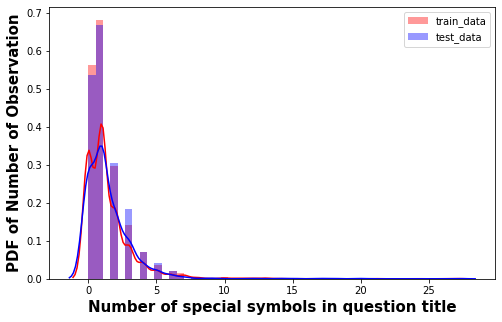

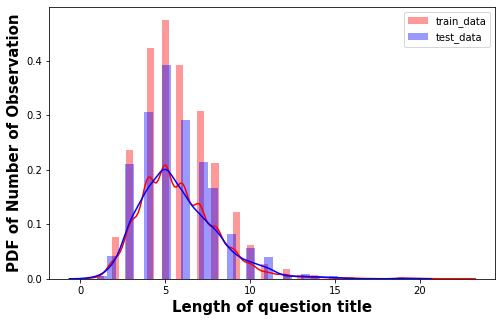

In [19]:
print('='*100)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))
sns.distplot(X_train['question_title_special_symbols'], label = 'train_data', color ='r' )
sns.distplot(X_test['question_title_special_symbols'], label = 'test_data', color ='b')
plt.xlabel('Number of special symbols in question title', fontweight ='bold', fontsize = 15)
plt.ylabel('PDF of Number of Observation', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

print('='*100)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))
sns.distplot(X_train['question_title_length'], label = 'train_data', color ='r')
sns.distplot(X_test['question_title_length'], label = 'test_data', color ='b')
plt.xlabel('Length of question title', fontweight ='bold', fontsize = 15)
plt.ylabel('PDF of Number of Observation', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

print('='*100)

In [20]:
print("Mean number of symbol in question title :", np.mean(X_train['question_title_special_symbols']))
print("Mean length of question title :", np.mean(X_train['question_title_length']))

Mean number of symbol in question title : 1.4665844129138392
Mean length of question title : 5.776475426691343


#### 3.2.2. Analysis of question_body 

In [22]:
miss = len(X_train['question_body'].isnull())
total = len(X_train['question_body'])
print(f"Number of NULL Values in question body, {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")
print("Number of unique Values ", X_train['question_body'].nunique())

miss = len(X_test['question_body'].isnull())
total = len(X_test['question_body'])
print(f"Number of NULL Values {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")
print("Number of unique Values ", X_test['question_body'].nunique())


Number of NULL Values in question body, 4863 out if 4863. Percent of missing value: 0.0%.
Number of unique Values  3190
Number of NULL Values 1216 out if 1216. Percent of missing value: 0.0%.
Number of unique Values  1091


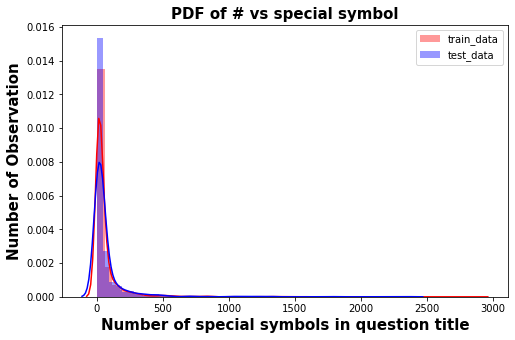

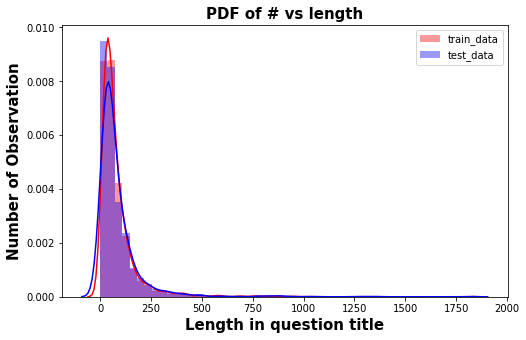

In [23]:
print('='*100)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))
sns.distplot(X_train['question_body_special_symbols'], label = 'train_data', color ='r' )
sns.distplot(X_test['question_body_special_symbols'], label = 'test_data', color ='b')
plt.xlabel('Number of special symbols in question title', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Observation', fontweight ='bold', fontsize = 15)
plt.title("PDF of # vs special symbol", fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

print('='*100)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))
sns.distplot(X_train['question_body_length'], label = 'train_data', color ='r')
sns.distplot(X_test['question_body_length'], label = 'test_data', color ='b')
plt.xlabel('Length in question title', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Observation', fontweight ='bold', fontsize = 15)
plt.title("PDF of # vs length", fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

print('='*100)

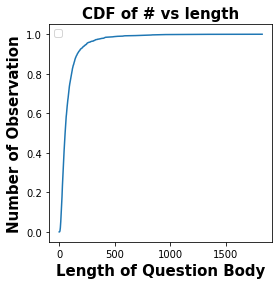

In [24]:
# percentile values
question_body_percentile = []
train_tmp = X_train['question_body_length'].value_counts().sort_index().cumsum()
train_tmp = train_tmp / max(train_tmp)
# plot the WordCloud image                      
plt.figure(figsize = (4, 4), facecolor = None)

plt.plot(train_tmp)
plt.legend()
plt.xlabel("Length of Question Body", fontweight ='bold', fontsize = 15)
plt.ylabel("Number of Observation", fontweight ='bold', fontsize = 15)
plt.title("CDF of # vs length", fontweight ='bold', fontsize = 15)
plt.show()

#### 3.2.3. Analysis of answer

In [26]:
miss = len(X_train['answer'].isnull())
total = len(X_train['answer'])
print(f"Number of NULL Values in question body, {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")
print("Number of unique Values ", X_train['answer'].nunique())

miss = len(X_test['answer'].isnull())
total = len(X_test['answer'])
print(f"Number of NULL Values {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")
print("Number of unique Values ", X_test['answer'].nunique())


Number of NULL Values in question body, 4863 out if 4863. Percent of missing value: 0.0%.
Number of unique Values  4863
Number of NULL Values 1216 out if 1216. Percent of missing value: 0.0%.
Number of unique Values  1216


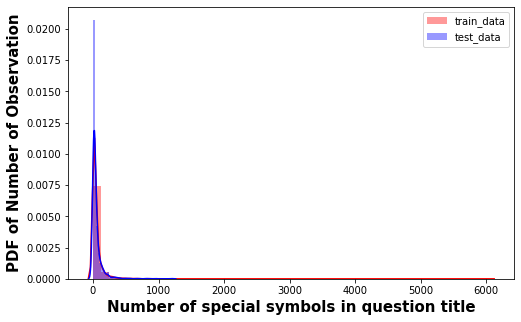

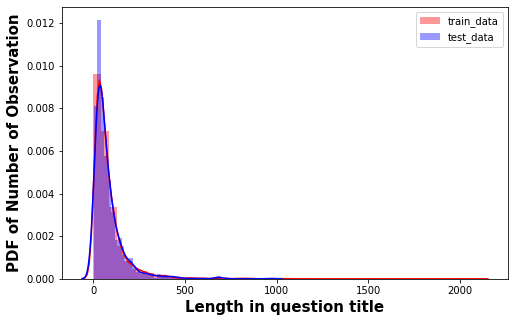

In [27]:
print('='*100)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))
sns.distplot(X_train['answer_special_symbols'], label = 'train_data', color ='r' )
sns.distplot(X_test['answer_special_symbols'], label = 'test_data', color ='b')
plt.xlabel('Number of special symbols in question title', fontweight ='bold', fontsize = 15)
plt.ylabel('PDF of Number of Observation', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

print('='*100)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))
sns.distplot(X_train['answer_length'], label = 'train_data', color ='r')
sns.distplot(X_test['answer_length'], label = 'test_data', color ='b')
plt.xlabel('Length in question title', fontweight ='bold', fontsize = 15)
plt.ylabel('PDF of Number of Observation', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

print('='*100)

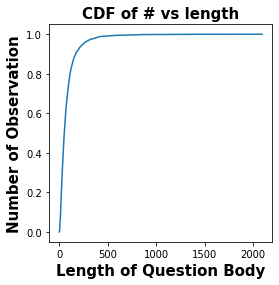

In [28]:
# percentile values
question_body_percentile = []
train_tmp = X_train['answer_length'].value_counts().sort_index().cumsum()
train_tmp = train_tmp / max(train_tmp)
# plot the WordCloud image                      
plt.figure(figsize = (4, 4), facecolor = None)

plt.plot(train_tmp)
plt.xlabel("Length of Question Body", fontweight ='bold', fontsize = 15)
plt.ylabel("Number of Observation", fontweight ='bold', fontsize = 15)
plt.title("CDF of # vs length", fontweight ='bold', fontsize = 15)
plt.show()

Final EDA Observation:
<li> For same question title and body mutiple answer available. <br>
<li> Usable features are category, host, question_title, question_body, answer. <br>


## 4. Feature Engineering
<a id='4'></a>

In [30]:

# Binary Encoding of Categorical Feature: host
binaryencoder = ce.BinaryEncoder() 
X_train_host = binaryencoder.fit_transform(X_train['host'])
X_test_host = binaryencoder.transform(X_test['host'])

# Binary Encoding of Categorical Feature: category
binaryencoder = ce.BinaryEncoder() 
X_train_category = binaryencoder.fit_transform(X_train['category'])
X_test_category = binaryencoder.fit_transform(X_test['category'])

In [31]:
X_train['preprocessed_question'] = X_train['preprocessed_question_title'] + X_train['preprocessed_question_body']
X_test['preprocessed_question'] = X_test['preprocessed_question_title'] + X_test['preprocessed_question_body']

vectorizer = TfidfVectorizer(ngram_range = (1,4), min_df=4)
X_train_question_tfidf = vectorizer.fit_transform(X_train['preprocessed_question'])
X_test_question_tfidf = vectorizer.transform(X_test['preprocessed_question'])

vectorizer = TfidfVectorizer(ngram_range = (1,4), min_df=4)
X_train_answer_tfidf = vectorizer.fit_transform(X_train['preprocessed_answer'])
X_test_answer_tfidf = vectorizer.transform(X_test['preprocessed_answer'])


In [32]:
X_train_answer_tfidf.shape

(4863, 11936)

In [33]:
X_train_A = pd.concat([pd.DataFrame(X_train_question_tfidf.toarray()), X_train_host.reset_index(drop = True), X_train_category.reset_index(drop = True), X_train[['question_title_length', 'question_body_length', 'answer_length', 'question_title_special_symbols', 'question_body_special_symbols',	'answer_special_symbols']].reset_index(drop = True)], axis=1)
X_test_A = pd.concat([pd.DataFrame(X_test_question_tfidf.toarray()), X_test_host.reset_index(drop = True), X_test_category.reset_index(drop = True), X_test[['question_title_length', 'question_body_length', 'answer_length', 'question_title_special_symbols', 'question_body_special_symbols',	'answer_special_symbols']].reset_index(drop = True)], axis=1)

In [34]:
print(X_train_A.shape)
print(X_test_A.shape)
print(y_train.shape)
print(y_test.shape)

(4863, 29510)
(1216, 29510)
(4863, 30)
(1216, 30)


In [35]:
X_train_B = pd.concat([pd.DataFrame(X_train_answer_tfidf.toarray()), X_train_host.reset_index(drop = True), X_train_category.reset_index(drop = True), X_train[['question_title_length', 'question_body_length', 'answer_length', 'question_title_special_symbols', 'question_body_special_symbols',	'answer_special_symbols']].reset_index(drop = True)], axis=1)
X_test_B = pd.concat([pd.DataFrame(X_test_answer_tfidf.toarray()), X_test_host.reset_index(drop = True), X_test_category.reset_index(drop = True), X_test[['question_title_length', 'question_body_length', 'answer_length', 'question_title_special_symbols', 'question_body_special_symbols',	'answer_special_symbols']].reset_index(drop = True)], axis=1)

In [36]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
print(" ==== Features for Question Based Aspect ==== ")
print(X_train_A.shape)
print(X_test_A.shape)
print(" ==== Features for Answer Based Aspect ==== ")
print(X_train_B.shape)
print(X_test_B.shape)
print(" ==== Labels ==== ")
print(y_train.shape)
print(y_test.shape)

 ==== Features for Question Based Aspect ==== 
(4863, 29510)
(1216, 29510)
 ==== Features for Answer Based Aspect ==== 
(4863, 11951)
(1216, 11951)
 ==== Labels ==== 
(4863, 30)
(1216, 30)


In [37]:
# saving train and test data
path = './'
# path = '../input/google-quest-challenge-files/'
if False:
# if True:
    X_train_A.to_csv(path+'X_train_A.csv', index=False)
    X_test_A.to_csv(path+'X_test_A.csv', index=False)
    X_train_B.to_csv(path+'X_train_B.csv', index=False)
    X_test_B.to_csv(path+'X_test_B.csv', index=False)
    y_train.to_csv(path+'y_train.csv', index=False)
    y_test.to_csv(path+'y_test.csv', index=False)

if False:
# if True:
    
    path = '../input/google-quest-challenge-files/'
    X_train_A = pd.read_csv(path+'X_train_A.csv')
    X_test_A = pd.read_csv(path+'X_test_A.csv')
    X_train_B = pd.read_csv(path+'X_train_B.csv')
    X_test_B = pd.read_csv(path+'X_test_B.csv')
    y_train = pd.read_csv(path+'y_train.csv')
    y_test = pd.read_csv(path+'y_test.csv')

In [38]:
y_label_question_names = ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
y_label_answer_names = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']

print("Number of labels related to question: ",len(y_label_question_names))
print("Number of labels related to answer: ", len(y_label_answer_names))

Number of labels related to question:  21
Number of labels related to answer:  9


In [39]:
class encoder_decoder:
    """
    Used to encode numberical label to classes
    """
    
    def __init__(self):
        pass

    def fit(self, array):
        # array = [i.round(6) for i in array]
        self.unique_labels = np.sort(np.unique(array))
        self.label_dict = {v:k for v,k in enumerate(self.unique_labels)}
        self.reverse_label_dict = {k:v for v,k in enumerate(self.unique_labels)}
        
    def encode(self, array):
        encoded_array = np.array([self.reverse_label_dict[i] for i in array])
        return encoded_array

    def decode(self, array):
        decoded_array = np.array([self.label_dict[i] for i in array])
        return decoded_array
    
# def accuracy_score(y_true,y_pred):
#     score = 0
#     for yt,yp in zip(y_true, y_pred):
#         if yt == yp:
#             score += 1
#     return score/len(y_true)

# def accuracy_score_off_by_1(y_true,y_pred):
#     score = 0
#     for yt,yp in zip(y_true, y_pred):
#         if yt == yp or yt == yp-1 or yt == yp+1:
#             score += 1
#     return score/len(y_true)

# Spearman's correlation coefficient
def spearmancoff(df, y_test):
    smr = 0
    for i in range(df.shape[0]):
        smr += stats.spearmanr(df.loc[i].values, y_test.loc[i].values)[0]
    return smr/df.shape[0]


In [40]:
Random_Pred = pd.DataFrame()
for aspect in y_label_question_names+y_label_answer_names:
    
    ytrain_ = y_train[aspect].values
    ytest_ = y_test[aspect].values
    
    ed = encoder_decoder()
    ed.fit(ytrain_)
    ytrain = ed.encode(ytrain_)
    ytest = ed.encode(ytest_)

    ypred = [random.choice(ed.unique_labels) for _ in range(len(ytest))]
    Random_Pred[aspect] = ypred
    
print("Spearman's correlation coefficient:-", spearmancoff(Random_Pred, y_test))

Spearman's correlation coefficient:- 0.15682009853912557


In [41]:
# pathPred = './'
pathPred = '../input/google-quest-challenge-files/predictions'

if not os.path.exists(os.path.join(pathPred, 'KNN_Pred.csv')):
# if True:        
    KNN_Pred = pd.DataFrame()
    KNN_Summary = pd.DataFrame(columns=['aspect', 'Best Hyperparameter', 'f1_macro'])
    for aspect in y_label_question_names+y_label_answer_names:
    
        ytrain_ = y_train[aspect].values
        ytest_ = y_test[aspect].values
        print("Model for aspect :", aspect)

        filename = f'KNN_{aspect}'

        ed = encoder_decoder()
        ed.fit(ytrain_)
        ytrain = ed.encode(ytrain_)
        ytest = ed.encode(ytest_)
        
#         path = './models'
#         path = './'
        path = '../input/google-quest-challenge-models'
        if not os.path.exists(os.path.join(path,filename)):

            parameters = {'n_neighbors':[x for x in range(3, 15, 2)]}
            x_cfl = KNeighborsClassifier()
            clf = GridSearchCV(x_cfl, parameters, n_jobs=4, scoring='f1_macro', cv=3, verbose=2, error_score="raise")
            
            if 'question' in aspect:
                clf.fit(X_train_A,ytrain)
                predict_y = clf.predict(X_test_A)
            else:
                clf.fit(X_train_B,ytrain)
                predict_y = clf.predict(X_test_B)

            sig_clf = clf.best_estimator_

            if 'question' in aspect:
                sig_clf.fit(X_train_A, ytrain)
            else:
                sig_clf.fit(X_train_B, ytrain)

            pickle.dump(sig_clf, open(os.path.join(path, filename), 'wb'))


        else:
            print("Model Exist! Loading ...")
            sig_clf = pickle.load(open(os.path.join(path,filename), 'rb'))

        if 'question' in aspect:
            result = sig_clf.predict(X_test_A)
        else:
            result = sig_clf.predict(X_test_B)
        
        KNN_Pred[aspect] = ed.decode(result) 
        KNN_Summary.loc[KNN_Summary.shape[0]] = [aspect, {'n_neighbors': sig_clf.get_params()['n_neighbors']}, f1_score(ytest, result, average='macro')]
    
    # print(KNN_Summary)
    KNN_Pred.to_csv((os.path.join('./', 'KNN_Pred.csv')),index=False)
    KNN_Summary.to_csv((os.path.join('./', 'KNN_Summary.csv')),index=False)
else:
    print("Prediction Exists ...")
    KNN_Pred = pd.read_csv(os.path.join(pathPred, 'KNN_Pred.csv'))
    
print("Spearman's correlation coefficient:-", spearmancoff(KNN_Pred, y_test))

Prediction Exists ...
Spearman's correlation coefficient:- 0.7390010246698369


In [42]:
KNN_Summary = pd.read_csv(os.path.join(pathPred, 'KNN_Summary.csv'))
KNN_Summary

,aspect,Best Hyperparameter,f1_macro
0,question_asker_intent_understanding,{'n_neighbors': 13},0.109651
1,question_body_critical,{'n_neighbors': 11},0.142898
2,question_conversational,{'n_neighbors': 7},0.188980
3,question_expect_short_answer,{'n_neighbors': 11},0.208309
4,question_fact_seeking,{'n_neighbors': 13},0.202243
5,question_has_commonly_accepted_answer,{'n_neighbors': 11},0.195741
6,question_interestingness_others,{'n_neighbors': 11},0.109338
7,question_interestingness_self,{'n_neighbors': 3},0.117947
8,question_multi_intent,{'n_neighbors': 13},0.186395
9,question_not_really_a_question,{'n_neighbors': 3},0.248344


In [43]:
# pathPred = './'
pathPred = '../input/google-quest-challenge-files/predictions'

if not os.path.exists(os.path.join(pathPred, 'LR_Pred.csv')):
# if True:        
    LR_Pred = pd.DataFrame()
    LR_Summary = pd.DataFrame(columns=['aspect', 'Best Hyperparameter', 'f1_macro'])
    for aspect in y_label_question_names+y_label_answer_names:
    
        ytrain_ = y_train[aspect].values
        ytest_ = y_test[aspect].values
        print("Model for aspect :", aspect)

        filename = f'LR_{aspect}'

        ed = encoder_decoder()
        ed.fit(ytrain_)
        ytrain = ed.encode(ytrain_)
        ytest = ed.encode(ytest_)
        
#         path = './models'
        path = '../input/google-quest-challenge-models'
        if not os.path.exists(os.path.join(path,filename)):

            parameters = {'C': [10 ** x for x in range(-4,3)]}
            x_cfl = LogisticRegression()
            clf = GridSearchCV(x_cfl, parameters, n_jobs=4, scoring='f1_macro', cv=3, verbose=5, error_score="raise")
            
            if 'question' in aspect:
                clf.fit(X_train_A,ytrain)
                predict_y = clf.predict(X_test_A)
            else:
                clf.fit(X_train_B,ytrain)
                predict_y = clf.predict(X_test_B)

            sig_clf = clf.best_estimator_

            if 'question' in aspect:
                sig_clf.fit(X_train_A, ytrain)
            else:
                sig_clf.fit(X_train_B, ytrain)

            pickle.dump(sig_clf, open(os.path.join('./', filename), 'wb'))


        else:
            print("Model Exist! Loading ...")
            sig_clf = pickle.load(open(os.path.join(path,filename), 'rb'))

        if 'question' in aspect:
            result = sig_clf.predict(X_test_A)
        else:
            result = sig_clf.predict(X_test_B)
        
        LR_Pred[aspect] = ed.decode(result) 
        LR_Summary.loc[LR_Summary.shape[0]] = [aspect, {'C': sig_clf.get_params()['C']}, f1_score(ytest, result, average='macro')]

    LR_Pred.to_csv((os.path.join(pathPred, 'LR_Pred.csv')),index=False)
    LR_Summary.to_csv((os.path.join(pathPred, 'LR_Summary.csv')),index=False)
else:
    print("Prediction Exists ...")
    LR_Pred = pd.read_csv(os.path.join(pathPred, 'LR_Pred.csv'))
    
print("Spearman's correlation coefficient:-", spearmancoff(LR_Pred, y_test))


Prediction Exists ...
Spearman's correlation coefficient:- 0.7524080005290991


In [44]:
LR_Summary = pd.read_csv(os.path.join(pathPred, 'LR_Summary.csv'))
LR_Summary

,aspect,Best Hyperparameter,f1_macro
0,question_asker_intent_understanding,{'C': 0.01},0.088473
1,question_body_critical,{'C': 100},0.109034
2,question_conversational,{'C': 1e-05},0.189163
3,question_expect_short_answer,{'C': 1e-05},0.161801
4,question_fact_seeking,{'C': 1e-05},0.150879
5,question_has_commonly_accepted_answer,{'C': 0.01},0.183272
6,question_interestingness_others,{'C': 1e-05},0.084877
7,question_interestingness_self,{'C': 1},0.067208
8,question_multi_intent,{'C': 0.001},0.161301
9,question_not_really_a_question,{'C': 1e-05},0.248344


In [45]:
# pathPred = './'
pathPred = '../input/google-quest-challenge-files/predictions'

if not os.path.exists(os.path.join(pathPred, 'RF_Pred.csv')):      
    RF_Pred = pd.DataFrame()
    RF_Summary = pd.DataFrame(columns=['aspect', 'Best Hyperparameter', 'f1_macro'])
    
    for aspect in y_label_question_names+y_label_answer_names:
    
        ytrain_ = y_train[aspect].values
        ytest_ = y_test[aspect].values
        print("Model for aspect :", aspect)

        filename = f'RF_{aspect}'

        ed = encoder_decoder()
        ed.fit(ytrain_)
        ytrain = ed.encode(ytrain_)
        ytest = ed.encode(ytest_)
        
#         path = './models'
        path = '../input/google-quest-challenge-models'
        if not os.path.exists(os.path.join(path,filename)):

            parameters = { 'n_estimators': [10,50,100,500,1000], 'max_depth': [50,100,200,500,1000]}
            x_cfl = RandomForestClassifier(n_jobs=-1)
            clf = GridSearchCV(x_cfl, parameters, n_jobs=4, scoring='f1_macro', cv=3, verbose=5, error_score="raise")

            if 'question' in aspect:
                clf.fit(X_train_A,ytrain)
                predict_y = clf.predict(X_test_A)
            else:
                clf.fit(X_train_B,ytrain)
                predict_y = clf.predict(X_test_B)

            sig_clf = clf.best_estimator_

            if 'question' in aspect:
                sig_clf.fit(X_train_A, ytrain)
            else:
                sig_clf.fit(X_train_B, ytrain)

            pickle.dump(sig_clf, open(os.path.join(path, filename), 'wb'))

        else:
            print("Model Exist! Loading ...")
            sig_clf = pickle.load(open(os.path.join(path,filename), 'rb'))

        if 'question' in aspect:
            result = sig_clf.predict(X_test_A)
        else:
            result = sig_clf.predict(X_test_B)
        
        RF_Pred[aspect] = ed.decode(result) 
        RF_Summary.loc[RF_Summary.shape[0]] = [aspect, str({'n_estimators': sig_clf.get_params()['n_estimators'], 'max_depth': sig_clf.get_params()['max_depth']}), f1_score(ytest, result, average='macro')]
        
    RF_Pred.to_csv((os.path.join(pathPred, 'RF_Pred.csv')),index=False)
    RF_Summary.to_csv((os.path.join(pathPred, 'RF_Summary.csv')),index=False)
else:
    print("Prediction Exists ...")
    RF_Pred = pd.read_csv(os.path.join(pathPred, 'RF_Pred.csv'))
    
print("Spearman's correlation coefficient:-", spearmancoff(RF_Pred, y_test))



Prediction Exists ...
Spearman's correlation coefficient:- 0.797911547534578


In [46]:
RF_Summary = pd.read_csv(os.path.join(pathPred, 'RF_Summary.csv'))
RF_Summary

,aspect,Best Hyperparameter,mean_f1_macro
0,question_asker_intent_understanding,"{'n_estimators': 100, 'max_depth': 10}",0.070412
1,question_body_critical,"{'n_estimators': 1000, 'max_depth': 1000}",0.204072
2,question_conversational,"{'n_estimators': 1000, 'max_depth': 10}",0.203029
3,question_expect_short_answer,"{'n_estimators': 500, 'max_depth': 50}",0.212890
4,question_fact_seeking,"{'n_estimators': 500, 'max_depth': 50}",0.232296
5,question_has_commonly_accepted_answer,"{'n_estimators': 500, 'max_depth': 100}",0.289682
6,question_interestingness_others,"{'n_estimators': 50, 'max_depth': 10}",0.081564
7,question_interestingness_self,"{'n_estimators': 500, 'max_depth': 50}",0.167667
8,question_multi_intent,"{'n_estimators': 1000, 'max_depth': 1000}",0.287905
9,question_not_really_a_question,"{'n_estimators': 500, 'max_depth': 50}",0.277545


In [47]:
# pathPred = './'
pathPred = '../input/google-quest-challenge-files/predictions'

if not os.path.exists(os.path.join(pathPred, 'XGB_Pred.csv')):
# if True:        
    XGB_Pred = pd.DataFrame()
    XGB_Summary = pd.DataFrame(columns=['aspect', 'Best Hyperparameter', 'f1_macro'])
    
    for aspect in y_label_question_names+y_label_answer_names:
    
        ytrain_ = y_train[aspect].values
        ytest_ = y_test[aspect].values
        print("Model for aspect :", aspect)

        filename = f'RF_{aspect}'

        ed = encoder_decoder()
        ed.fit(ytrain_)
        ytrain = ed.encode(ytrain_)
        ytest = ed.encode(ytest_)
        
#         path = './models'
        path = '../input/google-quest-challenge-models'
        if not os.path.exists(os.path.join(path,filename)):

            parameters = { 'n_estimators': [10,50,100,500,1000], 'max_depth': [50,100,200]}
            x_cfl = XGBClassifier(nthread=-1, eval_metric='mlogloss', tree_method= 'gpu_hist')
            clf = GridSearchCV(x_cfl, parameters, n_jobs=4, scoring='f1_macro', cv=3, verbose=5, error_score="raise")

            if 'question' in aspect:
                clf.fit(X_train_A,ytrain)
                predict_y = clf.predict(X_test_A)
            else:
                clf.fit(X_train_B,ytrain)
                predict_y = clf.predict(X_test_B)

            sig_clf = clf.best_estimator_

            if 'question' in aspect:
                sig_clf.fit(X_train_A, ytrain)
            else:
                sig_clf.fit(X_train_B, ytrain)

            pickle.dump(sig_clf, open(os.path.join(path, filename), 'wb'))


        else:
            print("Model Exist! Loading ...")
            sig_clf = pickle.load(open(os.path.join(path,filename), 'rb'))

        if 'question' in aspect:
            result = sig_clf.predict(X_test_A)
        else:
            result = sig_clf.predict(X_test_B)
        
        XGB_Pred[aspect] = ed.decode(result) 
        XGB_Summary.loc[XGB_Summary.shape[0]] = [aspect, str({'n_estimators': sig_clf.get_params()['n_estimators'], 'max_depth': sig_clf.get_params()['max_depth']}), f1_score(ytest, result, average='macro')]
        
    XGB_Pred.to_csv((os.path.join(pathPred, 'XGB_Pred.csv')),index=False)
    XGB_Summary.to_csv((os.path.join(pathPred, 'XGB_Summary.csv')),index=False)
else:
    print("Prediction Exists ...")
    XGB_Pred = pd.read_csv(os.path.join(pathPred, 'XGB_Pred.csv'))
    
print("Spearman's correlation coefficient:-", spearmancoff(RF_Pred, y_test))



Prediction Exists ...
Spearman's correlation coefficient:- 0.797911547534578


In [48]:
XGB_Summary = pd.read_csv(os.path.join(pathPred, 'XGB_Summary.csv'))
XGB_Summary

,aspect,Best Hyperparameter,f1_macro
0,question_asker_intent_understanding,"{'n_estimators': 100, 'max_depth': 10}",0.070412
1,question_body_critical,"{'n_estimators': 500, 'max_depth': 1000}",0.204072
2,question_conversational,"{'n_estimators': 500, 'max_depth': 10}",0.203029
3,question_expect_short_answer,"{'n_estimators': 500, 'max_depth': 50}",0.212890
4,question_fact_seeking,"{'n_estimators': 1000, 'max_depth': 50}",0.232296
5,question_has_commonly_accepted_answer,"{'n_estimators': 1000, 'max_depth': 100}",0.289682
6,question_interestingness_others,"{'n_estimators': 50, 'max_depth': 10}",0.081564
7,question_interestingness_self,"{'n_estimators': 100, 'max_depth': 50}",0.167667
8,question_multi_intent,"{'n_estimators': 500, 'max_depth': 1000}",0.287905
9,question_not_really_a_question,"{'n_estimators': 500, 'max_depth': 50}",0.277545


In [49]:
Final_Pred = pd.DataFrame()
for i in KNN_Pred.columns:
    Final_Pred[i] = ( (KNN_Pred[i] + LR_Pred[i] + RF_Pred[i] + XGB_Pred[i]) / 4)

print("Spearman's correlation coefficient:-", spearmancoff(Final_Pred, y_test))

Spearman's correlation coefficient:- 0.8094415752254648


In [50]:
w = [0.7390,0.7524,0.7979,0.7931] # weights of different models
Final_Pred = pd.DataFrame()
for i in KNN_Pred.columns:
    Final_Pred[i] = ( (KNN_Pred[i]*w[0] + LR_Pred[i]*w[1] + RF_Pred[i]*w[2] + XGB_Pred[i]*w[3]) / (sum(w)))

print("Spearman's correlation coefficient:-", spearmancoff(Final_Pred, y_test))

Spearman's correlation coefficient:- 0.8098598060093302


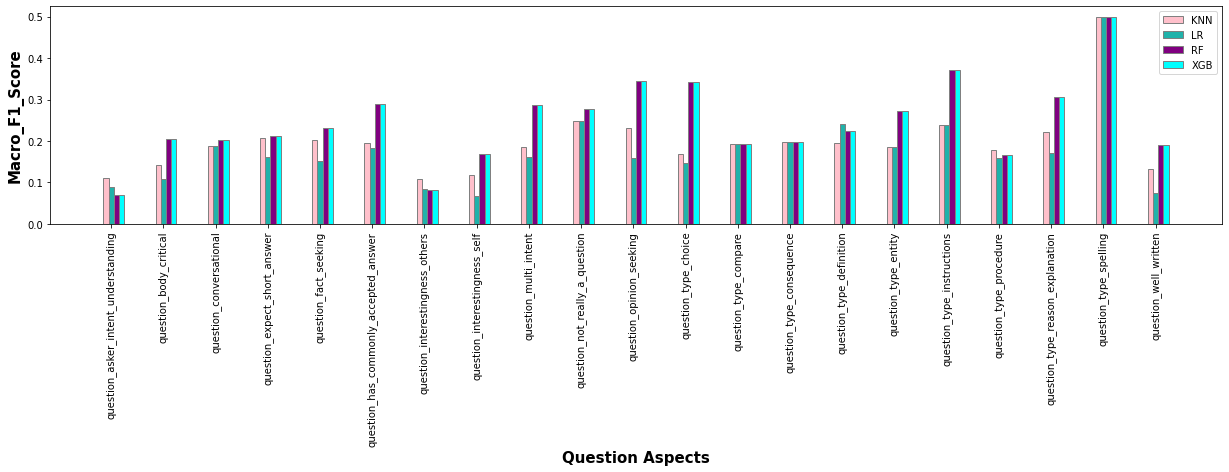

In [51]:
# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(21, 4))
 
# set height of bar
y1 = KNN_Summary['f1_macro'][:21]
y2 = LR_Summary['f1_macro'][:21]
y3 = RF_Summary['mean_f1_macro'][:21]
y4 = XGB_Summary['f1_macro'][:21]
 
# Set position of bar on X axis
br1 = np.arange(len(y1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, y1, color ='pink', width = barWidth,
        edgecolor ='grey', label ='KNN')
plt.bar(br2, y2, color ='#20B2AA', width = barWidth,
        edgecolor ='grey', label ='LR')
plt.bar(br3, y3, color ='purple', width = barWidth,
        edgecolor ='grey', label ='RF')
plt.bar(br4, y4, color ='cyan', width = barWidth,
        edgecolor ='grey', label ='XGB')
 
# Adding Xticks
plt.xlabel('Question Aspects', fontweight ='bold', fontsize = 15)
plt.ylabel('Macro_F1_Score', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(y1))],
        KNN_Summary['aspect'][:21].values, rotation=90)#, fontweight='bold')
 
plt.legend()
plt.show()

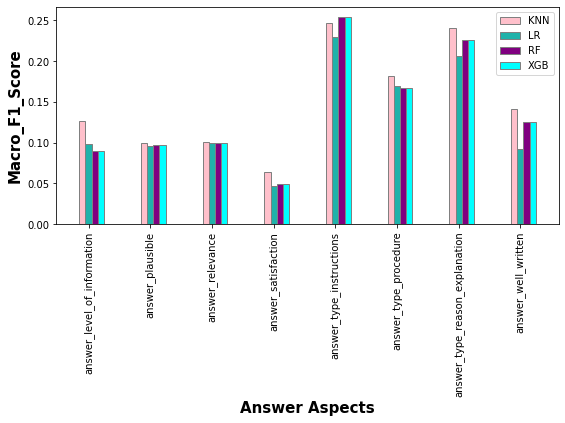

In [52]:
# set width of bar
barWidth = 0.1
fig = plt.subplots(figsize =(9, 4))
 
# set height of bar
y1 = KNN_Summary['f1_macro'][22:]
y2 = LR_Summary['f1_macro'][22:]
y3 = RF_Summary['mean_f1_macro'][22:]
y4 = XGB_Summary['f1_macro'][22:]
 
# Set position of bar on X axis
br1 = np.arange(len(y1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, y1, color ='pink', width = barWidth,
        edgecolor ='grey', label ='KNN')
plt.bar(br2, y2, color ='#20B2AA', width = barWidth,
        edgecolor ='grey', label ='LR')
plt.bar(br3, y3, color ='purple', width = barWidth,
        edgecolor ='grey', label ='RF')
plt.bar(br4, y4, color ='cyan', width = barWidth,
        edgecolor ='grey', label ='XGB')
 
# Adding Xticks
plt.xlabel('Answer Aspects', fontweight ='bold', fontsize = 15)
plt.ylabel('Macro_F1_Score', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(y1))],
        KNN_Summary['aspect'][22:].values, rotation=90)#, fontweight='bold')
 
plt.legend()
plt.show()

In [53]:
import pandas as pd
Result = pd.DataFrame(columns = ['Model', 'Spearman correlation coefficient'])
Result.loc[len(Result.index)] = ['Random Model', 0.1557]
Result.loc[len(Result.index)] = ['K-Nearest Neighbor', 0.7390]
Result.loc[len(Result.index)] = ['Logistic Regression', 0.7524]
Result.loc[len(Result.index)] = ['XGBoost', 0.7931]
Result.loc[len(Result.index)] = ['Random Forest', 0.7979]
Result.loc[len(Result.index)] = ['Average of KNN, LR, RF, XGB', 0.8199]
Result.loc[len(Result.index)] = ['Weighted Average of KNN, LR, RF, XGB', 0.8205]
Result

,Model,Spearman correlation coefficient
0,Random Model,0.1557
1,K-Nearest Neighbor,0.7390
2,Logistic Regression,0.7524
3,XGBoost,0.7931
4,Random Forest,0.7979
5,"Average of KNN, LR, RF, XGB",0.8199
6,"Weighted Average of KNN, LR, RF, XGB",0.8205
